# Plotmaker
This is the file used to analyze and visualize runlogs generated by the training

In [36]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

hist_dir = './history/'
imgs_dir = './images/'
city_dir = '../cities/'

city_file = 'test_5_intersection.html'
hist_file = 'history_agent_gcnn_2023-04-28_22-50_test_5_intersection.csv'
out_name = hist_file.removeprefix('history_').removesuffix('.csv')

In [11]:
def letter_to_number(letter: str) -> int:
    if len(letter) == 1:  # A, B, C
        return ord(letter) - ord('A')
    else:  # A1, B1, C1
        return int(letter[1:]) * 26 + ord(letter[0]) - ord('A')

def number_to_letter(num: int) -> str:
    if num < 26:
        return chr(num + 65)
    else:
        return chr(num % 26 + 65) + str(num // 26)
    
def save_fig(fig_id: str, tight_layout: bool = True, fig_extension: str = "png", resolution: int = 200):
    path = os.path.join(imgs_dir, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Read points 

In [3]:
df_city = pd.read_html(city_dir + city_file)[0]

df_city.set_index('Name', drop=True, inplace=True)
df_city.sort_values(by=['Name'], inplace=True)
ind = ['Point' in x for x in list(df_city.index)]

df_points = df_city.loc[ind].dropna(axis=1)  # Name, (x, y)
df_segments = df_city.loc[[not x for x in ind]].reset_index().drop('Name', axis=1)

# Process points
df_points.index = [x.split(' ')[1] for x in list(df_points.index)]  # Get only letter
df_points['Value'] = [re.findall(r'[\d.]+', x) for x in df_points['Value']]  # Find coordinates
df_points['Value'] = [tuple([float(x) for x in lst]) for lst in df_points['Value']]  # Convert coords to float
points = {letter_to_number(x): y for x, y in zip(list(df_points.index), df_points['Value'])}  # {ID: (x, y), ...}

### Read logs

In [4]:
df_logs = pd.read_csv(hist_dir + hist_file, sep='\t')
df_logs_g = pd.DataFrame(df_logs.groupby(by='end').sum().loc[:, 'reward'])
df_logs_g['x'] = [points[x][0] for x in df_logs_g.index]
df_logs_g['y'] = [points[x][1] for x in df_logs_g.index]
display(df_logs_g.head())

,reward,x,y
end,,,
0.0,7496255.0,74.23,80.31
1.0,4082218.0,189.02,248.52
2.0,11856573.0,350.00,100.00
3.0,9826037.0,323.75,377.66
4.0,3411650.0,82.20,405.56


Saving figure junction_reward_plot_agent_gcnn_2023-04-28_22-50_test_5_intersection


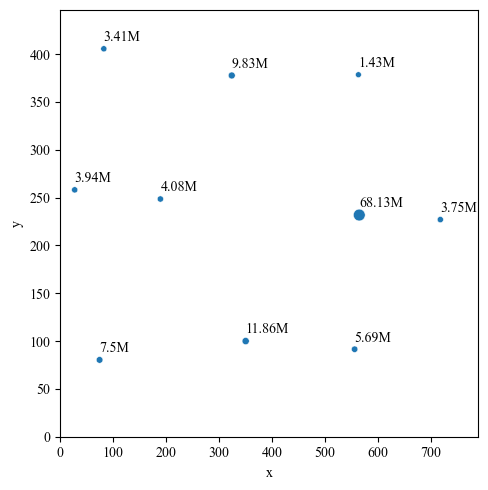

In [38]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_logs_g, x='x', y='y', size='reward')
plt.xlim([0, max(df_logs_g.x) * 1.1])
plt.ylim([0, max(df_logs_g.y) * 1.1])
plt.legend().remove()
for i in range(len(df_logs_g)):
    rec = df_logs_g.iloc[i, :]
    plt.text(rec.x, rec.y + 8, f'{round(rec.reward / 1e6, 2)}M')
save_fig(f'junction_reward_plot_{out_name}')
plt.show()